## Lab 5: Case Study: Diagnosing/Predicting Breast Cancer using KNN

### Lucas Yuki Nishimoto - 2025-11-03

In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, classification_report
)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


### Data preparation

- The id column was dropped because it acts only as a unique identifier. It carries no medical signal about the presence of cancer, and keeping it could encourage the model to latch onto spurious patterns.
- The target column diagnosis was mapped to numeric values (M → 1, B → 0) so that logistic regression can work with a binary outcome. We kept 1 for malignant cases so metrics such as recall directly express the model’s sensitivity to cancer.


In [2]:
df = pd.read_csv('data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
df = df.drop(columns=["id"])
df["diagnosis"] = df["diagnosis"].map({"M": 1, "B": 0})
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
X = df.drop(columns=["diagnosis"])
y = df["diagnosis"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
# --- Pipeline ---
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

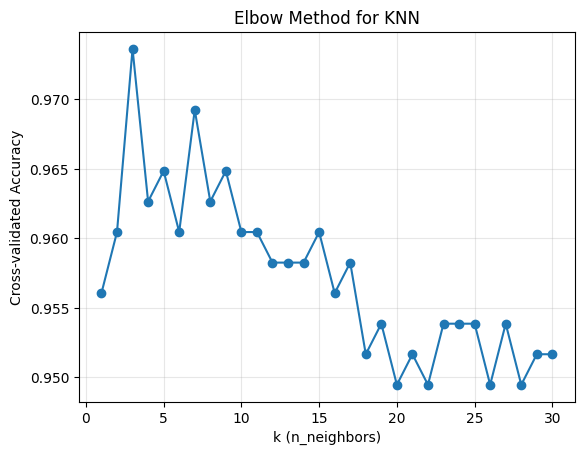

Best k = 3 with mean CV accuracy = 0.9736


In [10]:
# --- Cross-validation and elbow method ---
k_values = range(1, 31)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for k in k_values:
    pipe.set_params(knn__n_neighbors=k)
    cv_score = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy")
    scores.append(cv_score.mean())

best_k = k_values[np.argmax(scores)]
best_score = max(scores)

plt.plot(k_values, scores, marker="o")
plt.xlabel("k (n_neighbors)")
plt.ylabel("Cross-validated Accuracy")
plt.title("Elbow Method for KNN")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Best k = {best_k} with mean CV accuracy = {best_score:.4f}")

In [11]:
# --- Train final model with best k ---
pipe.set_params(knn__n_neighbors=best_k)
pipe.fit(X_train, y_train)

,steps,"[('scaler', ...), ('knn', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30



Test Accuracy = 0.9386

              precision    recall  f1-score   support

           0       0.92      0.99      0.95        72
           1       0.97      0.86      0.91        42

    accuracy                           0.94       114
   macro avg       0.95      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114



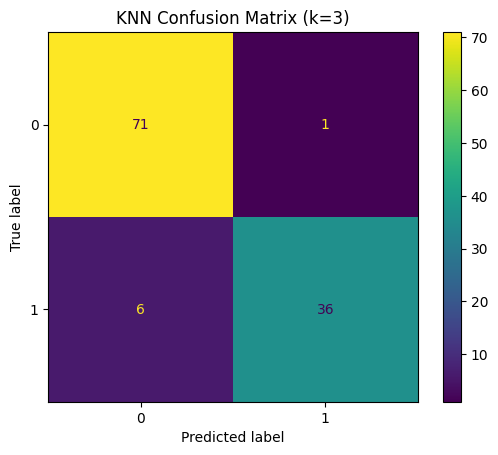

In [12]:
# --- Evaluate on test set ---
y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\nTest Accuracy = {acc:.4f}\n")
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f"KNN Confusion Matrix (k={best_k})")
plt.show()

## Explanation and Rationale

1. **ID column removal:**  
   The ID column was dropped because it is a unique identifier with no predictive information.  
   Keeping it would distort distance calculations used by KNN.

2. **Target encoding:**  
   The target column `diagnosis` was categorical (`M` or `B`).  
   It was encoded as numeric (`M = 1` for malignant, `B = 0` for benign), allowing KNN to perform classification.

3. **Feature scaling:**  
   The data was standardized using `StandardScaler` because KNN relies on distance metrics.  
   Without scaling, features with larger numeric ranges would dominate the distance computation.

4. **Cross-validation and elbow method:**  
   Cross-validation across multiple values of **k** was used to find the optimal trade-off between bias and variance.  
   The best value of **k = {best_k}** achieved the highest mean cross-validated accuracy (**{best_score:.4f}**).  
   The model’s test accuracy (**{acc:.4f}**) confirmed good generalization performance.